In [1]:
# import libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_error

In [2]:
# load dataset
machine = 'm_3330.csv'
workload = pd.read_csv(machine, 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


In [3]:
# reshape dataset
dataset = workload.cpu.values
dataset = np.reshape(dataset, (-1, 1))

dataset[:5]

array([[17.],
       [24.],
       [16.],
       [16.],
       [16.]])

In [4]:
dataset.shape

(11520, 1)

In [5]:
# normalize dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset[:5]

array([[0.02666667],
       [0.12      ],
       [0.01333333],
       [0.01333333],
       [0.01333333]])

In [6]:
# split dataset in train and test sets
train_proportion = 0.8
train_size = int(len(dataset) * train_proportion)

train_set = dataset[:train_size]
test_set = dataset[train_size:]

train_set.shape, test_set.shape

((9216, 1), (2304, 1))

In [7]:
# generate input (X) and output (y) parameters for model
def extract_x_y(data, x_size):
    X, y =[], []
    for pos in range(len(data) - x_size):
        end_pos = pos + x_size
        X.append(data[pos:end_pos,])
        y.append(data[end_pos,])
    return np.reshape(np.array(X),(-1,1,x_size)), np.array(y)

x_size = 60
X_train, y_train = extract_x_y(train_set, x_size)
X_test, y_test = extract_x_y(test_set, x_size)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9156, 1, 60), (9156, 1), (2244, 1, 60), (2244, 1))

In [8]:
# fit model
def model_lstm(x_size):
    model=Sequential()
    model.add(LSTM(100, input_shape=(1, x_size), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse'])
    return model

model=model_lstm(x_size)
history = model.fit(X_train, y_train, epochs=1000, batch_size=30, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=1000)], verbose=0, shuffle=False)

In [9]:
# validate predict with test set
def validate(y_test, pred):
    mse = mean_squared_error(y_test, pred)
    print(f'mean_squared_error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'root_mean_squared_error: {rmse}')
    cd = r2_score(y_test, pred)
    print(f'Determination coeficient: {cd}')
    ev = explained_variance_score(y_test, pred)
    print(f'explained_variance_score: {ev}')
    me = max_error(y_test, pred)
    print(f'max_error: {me}')
    mae = mean_absolute_error(y_test, pred)
    print(f'mean_absolute_error: {mae}')

In [10]:
# get predict
predict = model.predict(X_test)[:,0]
real = y_test[:,0]

validate(real, predict)

pd.DataFrame({'real':real, 'predic':predict, 'absolute error':np.absolute(real-predict)})

mean_squared_error: 0.009949028111630112
root_mean_squared_error: 0.09974481496113025
Determination coeficient: 0.5190315844902306
explained_variance_score: 0.5272700472419249
max_error: 0.813479364713033
mean_absolute_error: 0.07345537902359019


,real,predic,absolute error
0,0.440000,0.496088,0.056088
1,0.413333,0.457164,0.043830
2,0.346667,0.433497,0.086830
3,0.320000,0.429666,0.109666
4,0.346667,0.389716,0.043049
...,...,...,...
2239,0.133333,0.304818,0.171485
2240,0.080000,0.199725,0.119725
2241,0.146667,0.073484,0.073182
2242,0.106667,0.178147,0.071480


In [11]:
# get predict with reverse normalize
predict = scaler.inverse_transform(model.predict(X_test))[:,0]
real = scaler.inverse_transform(y_test)[:,0]

validate(real, predict)

pd.DataFrame({'real':real, 'predic':predict, 'absolute error':np.absolute(real-predict)})

mean_squared_error: 55.96328243152041
root_mean_squared_error: 7.480861075539393
Determination coeficient: 0.5190315904753315
explained_variance_score: 0.5272700462675322
max_error: 61.010955810546875
mean_absolute_error: 5.5091533597140385


,real,predic,absolute error
0,48.0,52.206615,4.206615
1,46.0,49.287281,3.287281
2,41.0,47.512249,6.512249
3,39.0,47.224972,8.224972
4,41.0,44.228664,3.228664
...,...,...,...
2239,25.0,37.861378,12.861378
2240,21.0,29.979389,8.979389
2241,26.0,20.511320,5.488680
2242,23.0,28.360996,5.360996


<AxesSubplot:>

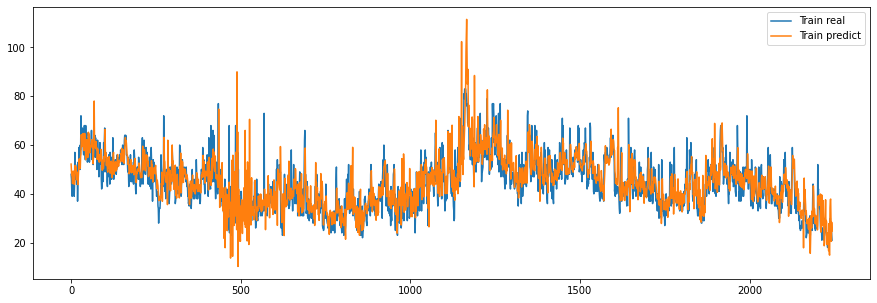

In [12]:
# plot predict
test_results = pd.DataFrame({'Train real':real, 'Train predict': predict})
test_results.plot(figsize=(15,5))